# Recommender Systems 2020/21

### Practice - BPR for SLIM and MF

### State of the art machine learning algorithm

## A few info about gradient descent

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.optimize import fmin

### Gradient Descent

<b>Gradient descent</b>, also known as <b>steepest descent</b>, is an optimization algorithm for finding the local minimum of a function. To find a local minimum, the function "steps" in the  direction of the negative of the gradient. <b>Gradient ascent</b> is the same as gradient descent, except that it steps in the direction of the positive of the gradient and therefore finds local maximums instead of minimums. The algorithm of gradient descent can be outlined as follows:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; choose $\alpha_k$ to minimize $f(x_k+\alpha_k s_k)$ <br>
&nbsp;&nbsp;&nbsp;    5:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \alpha_k s_k$ <br>
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>end for</b>

As a simple example, let's find a local minimum for the function $f(x) = x^3-2x^2+2$

In [2]:
f = lambda x: x**3-2*x**2+2

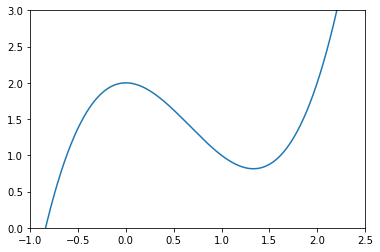

In [3]:
x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

We can see from plot above that our local minimum is gonna be near around 1.4 or 1.5 (on the x-axis), but let's pretend that we don't know that, so we set our starting point (arbitrarily, in this case) at $x_0 = 2$

In [4]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.1 # step size
precision = 0.0001

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_gradient(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision:
    
    x_old = x_new
    
    # Gradient descent step
    s_k = -f_gradient(x_old)
    
    x_new = x_old + n_k * s_k
    
    x_list.append(x_new)
    y_list.append(f(x_new))
    
print ("Local minimum occurs at: {:.2f}".format(x_new))
print ("Number of steps:", len(x_list))

Local minimum occurs at: 1.33
Number of steps: 17


The figures below show the route that was taken to find the local minimum.

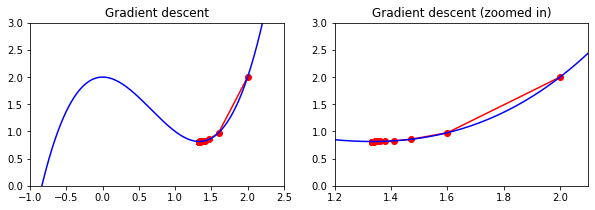

In [5]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")
plt.subplot(1,2,2)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([1.2,2.1])
plt.ylim([0,3])
plt.title("Gradient descent (zoomed in)")
plt.show()

## Recap on BPR
S.Rendle et al. BPR: Bayesian Personalized Ranking from Implicit Feedback. UAI2009

The usual approach for item recommenders is to predict a personalized score $\hat{x}_{ui}$ for an item that reflects the preference of the user for the item. Then the items are ranked by sorting them according to that score.

Machine learning approaches are tipically fit by using observed items as a positive sample and missing ones for the negative class. A perfect model would thus be useless, as it would classify as negative (non-interesting) all the items that were non-observed at training time. The only reason why such methods work is regularization.

BPR use a different approach. The training dataset is composed by triplets $(u,i,j)$ representing that user u is assumed to prefer i over j. For an implicit dataset this means that u observed i but not j:
$$D_S := \{(u,i,j) \mid i \in I_u^+ \wedge j \in I \setminus I_u^+\}$$

### BPR-OPT
A machine learning model can be represented by a parameter vector $\Theta$ which is found at fitting time. BPR wants to find the parameter vector that is most probable given the desired, but latent, preference structure $>_u$:
$$p(\Theta \mid >_u) \propto p(>_u \mid \Theta)p(\Theta) $$
$$\prod_{u\in U} p(>_u \mid \Theta) = \dots = \prod_{(u,i,j) \in D_S} p(i >_u j \mid \Theta) $$

The probability that a user really prefers item $i$ to item $j$ is defined as:
$$ p(i >_u j \mid \Theta) := \sigma(\hat{x}_{uij}(\Theta)) $$
Where $\sigma$ represent the logistic sigmoid and $\hat{x}_{uij}(\Theta)$ is an arbitrary real-valued function of $\Theta$ (the output of your arbitrary model).


To complete the Bayesian setting, we define a prior density for the parameters:
$$p(\Theta) \sim N(0, \Sigma_\Theta)$$
And we can now formulate the maximum posterior estimator:
$$BPR-OPT := \log p(\Theta \mid >_u) $$
$$ = \log p(>_u \mid \Theta) p(\Theta) $$
$$ = \log \prod_{(u,i,j) \in D_S} \sigma(\hat{x}_{uij})p(\Theta) $$
$$ = \sum_{(u,i,j) \in D_S} \log \sigma(\hat{x}_{uij}) + \log p(\Theta) $$
$$ = \sum_{(u,i,j) \in D_S} \log \sigma(\hat{x}_{uij}) - \lambda_\Theta ||\Theta||^2 $$

Where $\lambda_\Theta$ are model specific regularization parameters.

### BPR learning algorithm
Once obtained the log-likelihood, we need to maximize it in order to find our obtimal $\Theta$. As the crierion is differentiable, gradient descent algorithms are an obvious choiche for maximization.

Gradient descent comes in many fashions, you can find an overview on Cesare Bernardis thesis https://www.politesi.polimi.it/bitstream/10589/133864/3/tesi.pdf on pages 18-19-20. A nice post about momentum is available here https://distill.pub/2017/momentum/

The basic version of gradient descent consists in evaluating the gradient using all the available samples and then perform a single update. The problem with this is, in our case, that our training dataset is very skewed. Suppose an item i is very popular. Then we habe many terms of the form $\hat{x}_{uij}$ in the loss because for many users u the item i is compared against all negative items j.

The other popular approach is stochastic gradient descent, where for each training sample an update is performed. This is a better approach, but the order in which the samples are traversed is crucial. To solve this issue BPR uses a stochastic gradient descent algorithm that choses the triples randomly.

The gradient of BPR-OPT with respect to the model parameters is: 
$$\frac{\partial BPR-OPT}{\partial \Theta} = \sum_{(u,i,j) \in D_S} \frac{\partial}{\partial \Theta} \log \sigma (\hat{x}_{uij}) - \lambda_\Theta \frac{\partial}{\partial\Theta} || \Theta ||^2$$
$$ =  \sum_{(u,i,j) \in D_S} \frac{-e^{-\hat{x}_{uij}}}{1+e^{-\hat{x}_{uij}}} \frac{\partial}{\partial \Theta}\hat{x}_{uij} - \lambda_\Theta \Theta $$

### BPR-MF

In order to practically apply this learning schema to an existing algorithm, we first split the real valued preference term: $\hat{x}_{uij} := \hat{x}_{ui} − \hat{x}_{uj}$. And now we can apply any standard collaborative filtering model that predicts $\hat{x}_{ui}$.

The problem of predicting $\hat{x}_{ui}$ can be seen as the task of estimating a matrix $X:U×I$. With matrix factorization teh target matrix $X$ is approximated by the matrix product of two low-rank matrices $W:|U|\times k$ and $H:|I|\times k$:
$$X := WH^t$$
The prediction formula can also be written as:
$$\hat{x}_{ui} = \langle w_u,h_i \rangle = \sum_{f=1}^k w_{uf} \cdot h_{if}$$
Besides the dot product ⟨⋅,⋅⟩, in general any kernel can be used.

We can now specify the derivatives:
$$ \frac{\partial}{\partial \theta} \hat{x}_{uij} = \begin{cases}
(h_{if} - h_{jf}) \text{ if } \theta=w_{uf}, \\
w_{uf} \text{ if } \theta = h_{if}, \\
-w_{uf} \text{ if } \theta = h_{jf}, \\
0 \text{ else }
\end{cases} $$

Which basically means: user $u$ prefer $i$ over $j$, let's do the following:
- Increase the relevance (according to $u$) of features belonging to $i$ but not to $j$ and vice-versa
- Increase the relevance of features assigned to $i$
- Decrease the relevance of features assigned to $j$

We're now ready to look at some code!

# Let's implement SLIM BPR 

Once we have understood how BPR works, we can take the general formulation and adapt it to other models.
In order to implement SLIM BPR we simply need to replace $\hat{x}_{uij}$ with the corresponding prediction computed by the model that we want to optimize.

$ \hat{x}_{uij} = \hat{r}_{ui} - \hat{r}_{uj}= \sum_{k=0}^{I} r_{uk}S_{ki} - \sum_{k=0, k}^{I} r_{uk}S_{kj} = \sum_{k=0}^{I} r_{uk}(S_{ki} - S_{kj})$ 

#### Notice that we have two parameter sets for each sample, the weights of the positive item and those of the negative one, we have to update both and so we compute two gradients:

$\frac{\partial BPR-OPT}{\partial \Theta} = \sum_{(u,i,j) \in D_S} \frac{-e^{-\hat{x}_{uij}}}{1+e^{-\hat{x}_{uij}}} \frac{\partial}{\partial \Theta}\hat{x}_{uij} - \lambda_\Theta \Theta$

$\frac{\partial}{\partial S_{:i}}\hat{x}_{uij} = r_{u:}$

$\frac{\partial}{\partial S_{:j}}\hat{x}_{uij} = -r_{u:}$





In [6]:
import time
import numpy as np

### What do we need for a SLIM BPR?

* Item-Item similarity matrix
* Computing prediction
* Update rule
* Training loop and some patience


In [7]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

data_reader = Movielens10MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: <class 'Data_manager.Dataset.Dataset'>
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10217, feature occurrences: 108563, density 9.95E-04
	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10237, feature occurrences: 130127, density 1.19E-03




## Step 1: We create a dense similarity matrix, initialized as zero

In [8]:
n_users, n_items = URM_train.shape

In [9]:
item_item_S = np.zeros((n_items, n_items), dtype = np.float)
item_item_S

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Step 2: We sample a triplet

#### Create a mask of positive interactions. How to build it depends on the data

In [10]:
URM_mask = URM_train.copy()
URM_mask.data[URM_mask.data <= 3] = 0

URM_mask.eliminate_zeros()
URM_mask

<69878x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 4707743 stored elements in Compressed Sparse Row format>

In [11]:
user_id = np.random.choice(n_users)
user_id

22782

### Get user seen items and choose one

In [12]:
user_seen_items = URM_mask.indices[URM_mask.indptr[user_id]:URM_mask.indptr[user_id+1]]
user_seen_items

array([  25,   27,   96,  101,  105,  108,  302,  311, 1003, 1300, 1487,
       1490, 1551, 1601, 3161], dtype=int32)

In [13]:
pos_item_id = np.random.choice(user_seen_items)
pos_item_id

101

### To select a negative item it's faster to just try again then to build a mapping of the non-seen items

In [14]:
neg_item_selected = False

# It's faster to just try again then to build a mapping of the non-seen items
while (not neg_item_selected):
    neg_item_id = np.random.randint(0, n_items)

    if (neg_item_id not in user_seen_items):
        neg_item_selected = True

neg_item_id

4760

## Step 2 - Computing prediction

#### The prediction depends on the model: SLIM, Matrix Factorization... 
#### Note that here the data is implicit so we do not multiply for the user rating, because it is always 1, we just sum the similarities of the seen items.

In [15]:
x_ui = item_item_S[pos_item_id, user_seen_items].sum()
x_uj = item_item_S[neg_item_id, user_seen_items].sum()

print("x_ui is {:.4f}, x_uj is {:.4f}".format(x_ui, x_uj))

x_ui is 0.0000, x_uj is 0.0000


## Step 3 - Computing gradient

#### The gradient depends on the objective function: RMSE, BPR... 

In [16]:
x_uij = x_ui - x_uj
x_uij

0.0

#### The original BPR paper uses the logarithm of the sigmoid of x_ij, whose derivative is the following

In [17]:
sigmoid_item = 1 / (1 + np.exp(x_uij))
sigmoid_item

0.5

## Step 4 - Update model

#### How to update depends on the model itself, here we have just one paramether, the similarity matrix, so we perform just one update. In matrix factorization we have two.

#### We need a learning rate, which influences how fast the model will change. Small ones lead to slower convergence but often higher results

In [18]:
learning_rate = 1e-3

item_item_S[pos_item_id, user_seen_items] += learning_rate * sigmoid_item
item_item_S[pos_item_id, pos_item_id] = 0

item_item_S[neg_item_id, user_seen_items] -= learning_rate * sigmoid_item
item_item_S[neg_item_id, neg_item_id] = 0

#### Usually there is no relevant change in the scores over a single iteration

In [19]:
x_i = item_item_S[pos_item_id, user_seen_items].sum()
x_j = item_item_S[neg_item_id, user_seen_items].sum()

print("x_i is {:.4f}, x_j is {:.4f}".format(x_i, x_j))

x_i is 0.0070, x_j is -0.0075


## Now we put everything in a training loop

In [20]:
def sample_triplet():
    
    non_empty_user = False
    
    while not non_empty_user:
        user_id = np.random.choice(n_users)
        user_seen_items = URM_mask.indices[URM_mask.indptr[user_id]:URM_mask.indptr[user_id+1]]
        
        if len(user_seen_items)>0:
            non_empty_user = True

    pos_item_id = np.random.choice(user_seen_items)

    neg_item_selected = False

    # It's faster to just try again then to build a mapping of the non-seen items
    while (not neg_item_selected):
        neg_item_id = np.random.randint(0, n_items)

        if (neg_item_id not in user_seen_items):
            neg_item_selected = True

    return user_id, pos_item_id, neg_item_id    

    

In [21]:
def train_one_epoch(item_item_S, learning_rate):

    start_time = time.time()
    for sample_num in range(n_users):

        # Sample triplet
        user_id, pos_item_id, neg_item_id = sample_triplet()
        
        user_seen_items = URM_mask.indices[URM_mask.indptr[user_id]:URM_mask.indptr[user_id+1]]

        # Prediction
        x_ui = item_item_S[pos_item_id, user_seen_items].sum()
        x_uj = item_item_S[neg_item_id, user_seen_items].sum()
        
        # Gradient
        x_uij = x_ui - x_uj

        sigmoid_item = 1 / (1 + np.exp(x_uij))
        
        # Update
        item_item_S[pos_item_id, user_seen_items] += learning_rate * sigmoid_item
        item_item_S[pos_item_id, pos_item_id] = 0

        item_item_S[neg_item_id, user_seen_items] -= learning_rate * sigmoid_item
        item_item_S[neg_item_id, neg_item_id] = 0

        # Print some stats
        if (sample_num +1)% 50000 == 0 or (sample_num +1) == n_users:
            elapsed_time = time.time() - start_time
            samples_per_second = (sample_num +1)/elapsed_time
            print("Iteration {} in {:.2f} seconds. Samples per second {:.2f}".format(sample_num+1, elapsed_time, samples_per_second))
         
            
    return item_item_S, samples_per_second

In [22]:
learning_rate = 1e-6
    
item_item_S = np.zeros((n_items, n_items), dtype = np.float)

for n_epoch in range(5):
    item_item_S, samples_per_second = train_one_epoch(item_item_S, learning_rate)

Iteration 50000 in 2.33 seconds. Samples per second 21429.37
Iteration 69878 in 3.18 seconds. Samples per second 21974.59
Iteration 50000 in 2.07 seconds. Samples per second 24114.87
Iteration 69878 in 2.87 seconds. Samples per second 24363.31
Iteration 50000 in 2.20 seconds. Samples per second 22715.52
Iteration 69878 in 2.97 seconds. Samples per second 23512.38
Iteration 50000 in 2.06 seconds. Samples per second 24321.61
Iteration 69878 in 2.91 seconds. Samples per second 24004.01
Iteration 50000 in 2.22 seconds. Samples per second 22537.08
Iteration 69878 in 3.01 seconds. Samples per second 23247.39


In [23]:
estimated_seconds = 8e6 * 10 / samples_per_second
print("Estimated time with the previous training speed is {:.2f} seconds, or {:.2f} minutes".format(estimated_seconds, estimated_seconds/60))

Estimated time with the previous training speed is 3441.25 seconds, or 57.35 minutes


### Common mistakes in using ML (based on last year's presentations)

* Use default parameters and then give up when results are not good
* Train for just 1 or 2 epochs
* Use huge learning rate or regularization parameters: 1, 50, 100

# BPR for MF

### What do we need for BPRMF?

* User factor and Item factor matrices
* Computing prediction
* Update rule
* Training loop and some patience


## Step 1: We create the dense latent factor matrices

In [24]:
num_factors = 10

user_factors = np.random.random((n_users, num_factors))
item_factors = np.random.random((n_items, num_factors))

In [25]:
user_factors

array([[0.7659779 , 0.3143565 , 0.26425909, ..., 0.78056121, 0.86843444,
        0.5185093 ],
       [0.67924292, 0.49266765, 0.02975383, ..., 0.53037521, 0.82714536,
        0.08431127],
       [0.1162911 , 0.14537291, 0.47275693, ..., 0.03857484, 0.68371271,
        0.38612273],
       ...,
       [0.65260609, 0.55514278, 0.69390257, ..., 0.41161263, 0.46967491,
        0.02719706],
       [0.50513679, 0.23330894, 0.66084978, ..., 0.50573155, 0.21205575,
        0.81472249],
       [0.92378248, 0.6938683 , 0.8175108 , ..., 0.20739599, 0.91706012,
        0.64776784]])

In [26]:
item_factors

array([[0.52519126, 0.20423293, 0.43566583, ..., 0.0459627 , 0.80736068,
        0.34986463],
       [0.71346571, 0.80265357, 0.2766895 , ..., 0.80716581, 0.95323986,
        0.93221669],
       [0.54155147, 0.71543082, 0.09198144, ..., 0.61615629, 0.10739024,
        0.7833634 ],
       ...,
       [0.78140293, 0.88435851, 0.29889247, ..., 0.67243557, 0.48467276,
        0.1449844 ],
       [0.54257934, 0.47111501, 0.44009355, ..., 0.36953606, 0.71166651,
        0.93331242],
       [0.85966759, 0.16708281, 0.38813289, ..., 0.37159929, 0.68552976,
        0.11156988]])

## Step 2 - Computing prediction

In [27]:
user_id, pos_item_id, neg_item_id = sample_triplet()
(user_id, pos_item_id, neg_item_id)

(69855, 36, 3306)

In [28]:
x_ui = np.dot(user_factors[user_id,:], item_factors[pos_item_id,:])
x_uj = np.dot(user_factors[user_id,:], item_factors[neg_item_id,:])

print("x_ui is {:.4f}, x_uj is {:.4f}".format(x_ui, x_uj))

x_ui is 2.0311, x_uj is 2.0837


## Step 3 - Computing gradient


In [29]:
x_uij = x_ui - x_uj
x_uij

-0.05262646490107015

In [30]:
sigmoid_item = 1 / (1 + np.exp(x_uij))
sigmoid_item

0.5131535805794873

## Step 4 - Update model

In [31]:
regularization = 1e-4
learning_rate = 1e-2

H_i = item_factors[pos_item_id,:]
H_j = item_factors[neg_item_id,:]
W_u = user_factors[user_id,:]


user_factors[user_id,:] += learning_rate * (sigmoid_item * ( H_i - H_j ) - regularization * W_u)
item_factors[pos_item_id,:] += learning_rate * (sigmoid_item * ( W_u ) - regularization * H_i)
item_factors[neg_item_id,:] += learning_rate * (sigmoid_item * (-W_u ) - regularization * H_j)


In [32]:
x_ui = np.dot(user_factors[user_id,:], item_factors[pos_item_id,:])
x_uj = np.dot(user_factors[user_id,:], item_factors[neg_item_id,:])

print("x_i is {:.4f}, x_j is {:.4f}".format(x_ui, x_uj))

x_i is 2.0481, x_j is 2.0707


In [33]:
x_uij = x_ui - x_uj
x_uij

-0.022670430897814953

In [34]:
def train_one_epoch(user_factors, item_factors, learning_rate):

    start_time = time.time()
    for sample_num in range(n_users):

        # Sample triplet
        user_id, pos_item_id, neg_item_id = sample_triplet()
        
        # Prediction
        x_ui = np.dot(user_factors[user_id,:], item_factors[pos_item_id,:])
        x_uj = np.dot(user_factors[user_id,:], item_factors[neg_item_id,:])
        
        # Gradient
        x_uij = x_ui - x_uj

        sigmoid_item = 1 / (1 + np.exp(x_uij))
                
        H_i = item_factors[pos_item_id,:]
        H_j = item_factors[neg_item_id,:]
        W_u = user_factors[user_id,:]


        user_factors[user_id,:] += learning_rate * (sigmoid_item * ( H_i - H_j ) - regularization * W_u)
        item_factors[pos_item_id,:] += learning_rate * (sigmoid_item * ( W_u ) - regularization * H_i)
        item_factors[neg_item_id,:] += learning_rate * (sigmoid_item * (-W_u ) - regularization * H_j)

        # Print some stats
        if (sample_num +1)% 50000 == 0 or (sample_num +1) == n_users:
            elapsed_time = time.time() - start_time
            samples_per_second = (sample_num +1)/elapsed_time
            print("Iteration {} in {:.2f} seconds. Samples per second {:.2f}".format(sample_num+1, elapsed_time, samples_per_second))
         
        
    return user_factors, item_factors, samples_per_second

In [35]:
learning_rate = 1e-6
num_factors = 10

user_factors = np.random.random((n_users, num_factors))
item_factors = np.random.random((n_items, num_factors))

for n_epoch in range(5):
    user_factors, item_factors, samples_per_second = train_one_epoch(user_factors, item_factors, learning_rate)

Iteration 50000 in 1.77 seconds. Samples per second 28252.49
Iteration 69878 in 2.66 seconds. Samples per second 26300.70
Iteration 50000 in 1.86 seconds. Samples per second 26826.71
Iteration 69878 in 2.60 seconds. Samples per second 26907.05
Iteration 50000 in 1.85 seconds. Samples per second 26957.57
Iteration 69878 in 2.56 seconds. Samples per second 27334.92
Iteration 50000 in 1.69 seconds. Samples per second 29620.48
Iteration 69878 in 2.35 seconds. Samples per second 29699.76
Iteration 50000 in 1.95 seconds. Samples per second 25631.02
Iteration 69878 in 2.68 seconds. Samples per second 26077.49


### Final notes on BPR
- BPR is very sensitive to the popularity bias of the dataset, so in unbalanced scenarios can lead to trivial recommendations (popular takes all)
- More advanced strategies exist that fine-tune the sampling process (WARP)
- The value range of your model predictions loses all meaning, you may have predictions >100 as well as negative numbers. This is not an issue if you only have to rank items but it becomes one if you want to buil hybrid methods and combine the prediction of multiple models. If you add a BPR model to the hybrid you likely will need to normalize the predictions in order to ensure they are within the same range as the other models, or you will need to adopt other strategies that build a hybrid based on the ranking and not on the absolute prediction value